In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import kurtosis

import datetime as dt

from IPython.display import clear_output

import gc
import sys
sys.path.append( 'info_metrics/')

from entropy_metrics import *

In [49]:
def column_merger(columns):
    columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in columns]
    return columns

def count_unique(series):
    return len(np.unique(series))

def mean_absolute_deviation(x):
    return np.mean(np.abs(x - np.mean(x)))

def mask_df(df, year, domain, traffic, day=None, month=None):
    if day != None:
        return ((df["year"] == year) & (df["day"] == day) & (df["domain"] == domain) & (df["trafficType"] == traffic))
    if month != None:
        return ((df["year"] == year) & (df["month"] == month) & (df["domain"] == domain) & (df["trafficType"] == traffic))
    if domain == None and traffic == None and day != None:
        return ((df["year"] == year) & (df["day"] == day))
    else:
        return ((df["year"] == year) & (df["domain"] == domain) & (df["trafficType"] == traffic))

def extract_top_domain(df, num_top_domains_per_year):
    """ TEMPORARY """
    num_top_domains = num_top_domains_per_year
    df_sort_2019 = df.mask(df1["year"]==2019).sort_values("sumCount", ascending=False).reset_index(drop=True)
    df_sort_2018 = df.mask(df1["year"]==2018).sort_values("sumCount", ascending=False).reset_index(drop=True)
    top_10_domains_2019 = df_sort_2019["domain"].unique()[0:num_top_domains]
    top_10_domains_2018 = df_sort_2018["domain"].unique()[0:num_top_domains]
    top_domains = np.unique(np.concatenate([top_10_domains_2019, top_10_domains_2018])).flatten()
    return top_domains


In [52]:
df = pd.read_parquet("../../data/small/A1.parquet")

unique_domains = df["domain"].unique()
unique_traffictype = df["trafficType"].unique()
unique_days = df["day"].unique()

df["date"] = pd.to_datetime(df['date'], format='%Y%m%d%H')

df1 = df.copy()

In [53]:
top_domains = extract_top_domain(df1, 5)
top_domains

array(['commons.wikimedia', 'de.wikipedia', 'en.wikipedia',
       'es.wikipedia', 'fr.wikipedia', 'ru.wikipedia'], dtype=object)

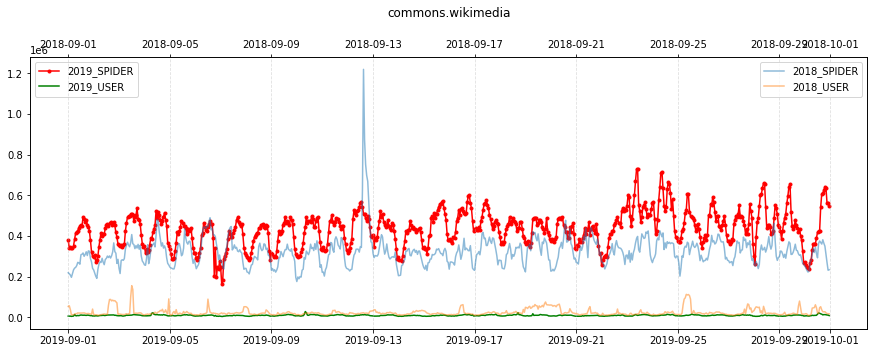

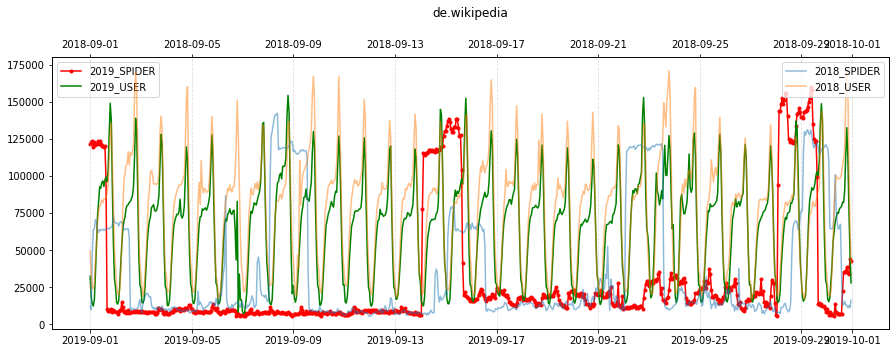

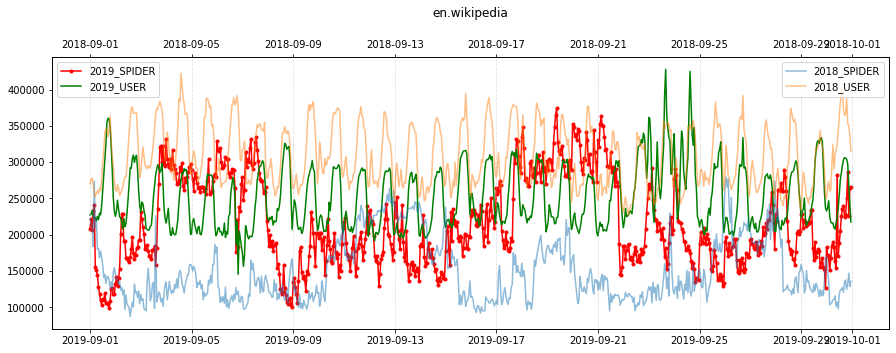

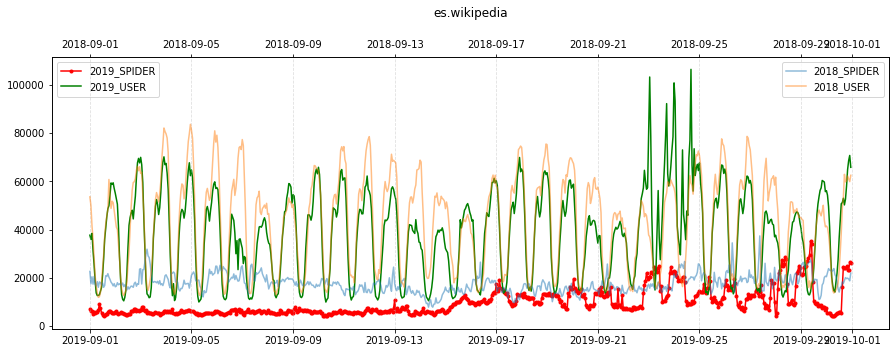

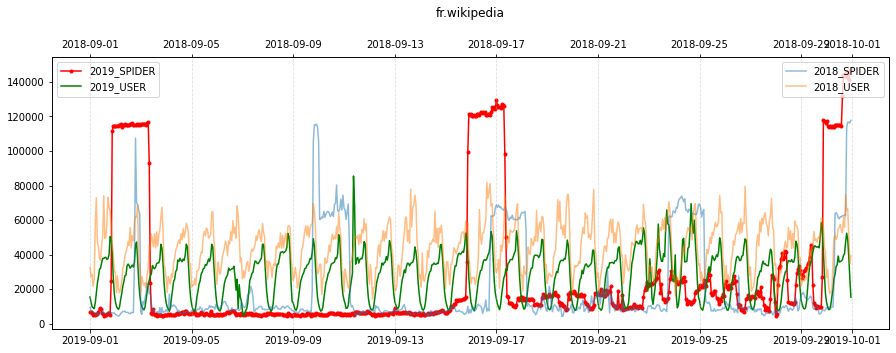

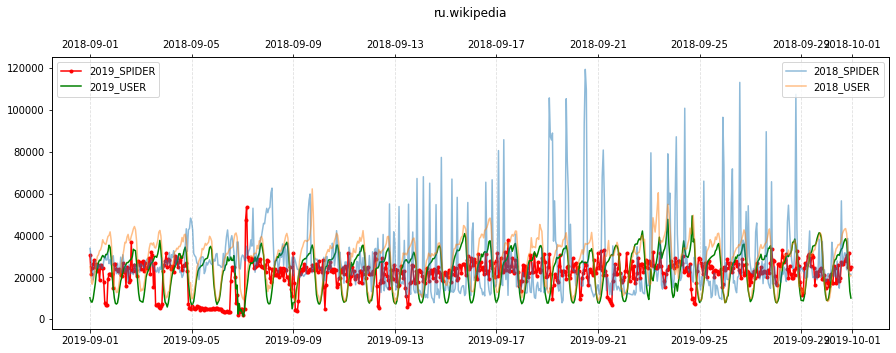

In [54]:
for domain in top_domains:

    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.set_title(domain, pad=40)
    ax1.plot(df1.date[mask_df(df1, 2019, domain, "spider")], df1.sumCount[mask_df(df1, 2019, domain, "spider")], color="r", marker=".", label="2019_SPIDER")
    ax1.plot(df1.date[mask_df(df1, 2019, domain, "user")], df1.sumCount[mask_df(df1, 2019, domain, "user")], color="g", label="2019_USER")
    ax1.legend(loc=2)

    ax2 = ax1.twiny()

    ax2.plot(df1.date[mask_df(df1, 2018, domain, "spider")], df1.sumCount[mask_df(df1, 2018, domain, "spider")], alpha=0.5, label="2018_SPIDER")
    ax2.plot(df1.date[mask_df(df1, 2018, domain, "user")], df1.sumCount[mask_df(df1, 2018, domain, "user")], alpha=0.5, label="2018_USER")
    ax2.legend(loc=1)

    plt.grid(linestyle="--", alpha=0.4)
    plt.show()


In [55]:
days = np.array(df1["day"].unique())
years = np.array([2018,2019])

KLV_ARRAY = np.zeros((len(days), len(top_domains)))
MI_ARRAY = np.zeros((len(days), len(top_domains)))
CENTROPY_ARRAY = np.zeros((len(days), len(top_domains)))
ENTROPY = np.zeros((len(years),len(days),len(top_domains)))


for i, day in enumerate(days):
    clear_output(wait=True)
    print("DAY: ", day)
    for j, domain in enumerate(top_domains):

        x = df1.sumCount[mask_df(df1, years[1], domain, "spider", day)].to_numpy()
        y = df1.sumCount[mask_df(df1, years[0], domain, "spider", day)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        ENTROPY[0, i, j]     = entropy(x, k=2)
        ENTROPY[1, i, j]     = entropy(y, k=2)
        MI_ARRAY[i, j]       = mi(x,y, k=2)
        KLV_ARRAY[i, j]      = kldiv(x,y, k=2)
        CENTROPY_ARRAY[i, j] = centropy(x,y, k=2)


DAY:  30


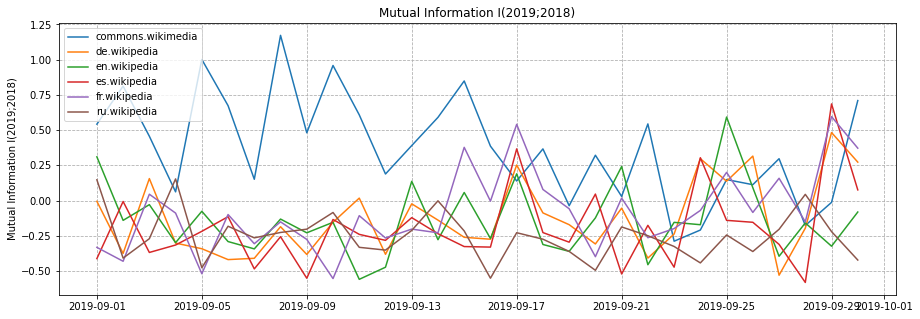

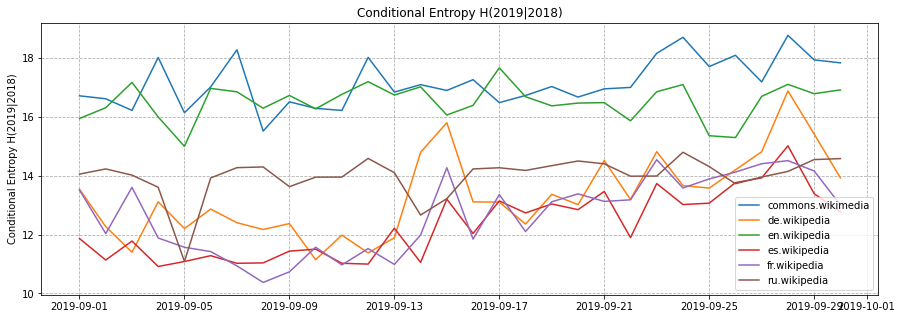

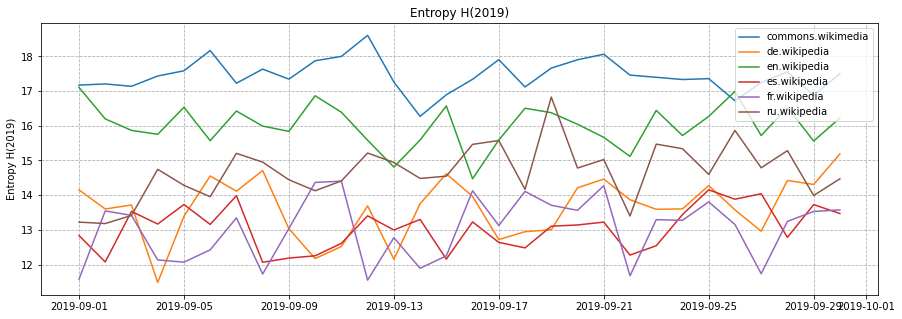

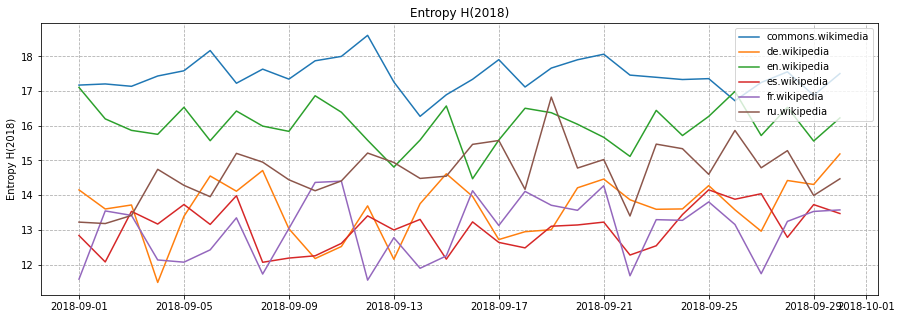

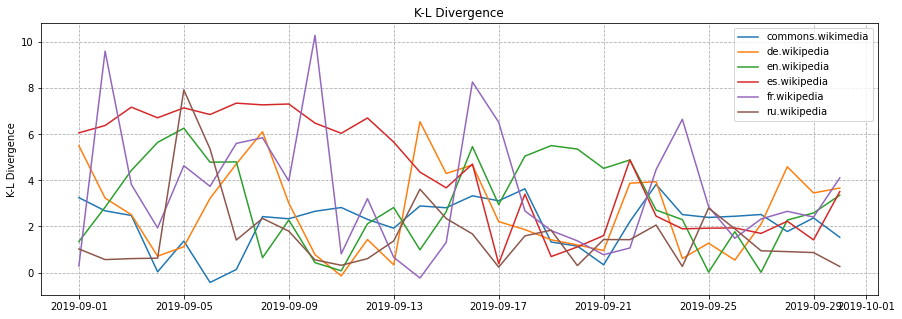

In [56]:
plt.figure(figsize=(15,5))
for i, domains in enumerate(top_domains):
    plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY[::,i], label=domains)
plt.grid(linestyle="--")
plt.title("Mutual Information I(2019;2018)")
plt.ylabel("Mutual Information I(2019;2018)")
plt.legend()
plt.show()
    
plt.figure(figsize=(15,5))
for i, domains in enumerate(top_domains):
    plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY[::,i], label=domains)
plt.grid(linestyle="--")
plt.title("Conditional Entropy H(2019|2018)")
plt.ylabel("Conditional Entropy H(2019|2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
for i, domains in enumerate(top_domains):
    plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY[1, ::,i], label=domains)
plt.grid(linestyle="--")
plt.title("Entropy H(2019)")
plt.ylabel("Entropy H(2019)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
for i, domains in enumerate(top_domains):
    plt.plot(df1.date[(df1["year"]==2018) & (df1["hour"]==0)].unique(), ENTROPY[1, ::,i], label=domains)
plt.grid(linestyle="--")
plt.title("Entropy H(2018)")
plt.ylabel("Entropy H(2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
for i, domains in enumerate(top_domains):
    plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY[::,i], label=domains)
plt.grid(linestyle="--")
plt.title("K-L Divergence")
plt.ylabel("K-L Divergence")
plt.legend()
plt.show()

# OneVal Per MonTH



In [57]:
days = np.array(df1["day"].unique())
years = np.array([2018,2019])
months = np.array([9])

KLV_ARRAY = np.zeros((len(months), len(top_domains)))
MI_ARRAY = np.zeros((len(months), len(top_domains)))
CENTROPY_ARRAY = np.zeros((len(months), len(top_domains)))
ENTROPY = np.zeros((len(years),len(months),len(top_domains)))


for i, month in enumerate(months):
    clear_output(wait=True)
    print("MONTH: ", month)
    for j, domain in enumerate(top_domains):

        x = df1.sumCount[mask_df(df1, years[1], domain, "spider", day=None, month=month)].to_numpy()
        y = df1.sumCount[mask_df(df1, years[0], domain, "spider", day=None, month=month)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        ENTROPY[0, i, j]     = entropy(x, k=2)
        ENTROPY[1, i, j]     = entropy(y, k=2)
        MI_ARRAY[i, j]       = mi(x,y, k=2)
        KLV_ARRAY[i, j]      = kldiv(x,y, k=2)
        CENTROPY_ARRAY[i, j] = centropy(x,y, k=2)


MONTH:  9


info_metrics/entropy_metrics.py:118: RuntimeWarning: divide by zero encountered in log
  return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)
info_metrics/entropy_metrics.py:118: RuntimeWarning: divide by zero encountered in log
  return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)
info_metrics/entropy_metrics.py:118: RuntimeWarning: invalid value encountered in double_scalars
  return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)


# Information theoretic-- Vector all top domains and traffic

In [60]:
df1 = df1.sort_values(by=["year", "month", "day", "hour", "trafficType", "domain"], ascending=True)
df1 = df1[df1["domain"].isin(top_domains)]
assert(df1[df1["year"]==2019].shape==df1[df1["year"]==2018].shape)

In [66]:
days = np.array(df1["day"].unique())
years = np.array([2018,2019])

KLV_ARRAY_CUM = np.zeros((len(days)))
MI_ARRAY_CUM = np.zeros((len(days)))
CENTROPY_ARRAY_CUM = np.zeros((len(days)))
ENTROPY_CUM = np.zeros((len(years),len(days)))


for i, day in enumerate(days):
    clear_output(wait=True)
    print("DAY: ", day)

    x = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[1])].to_numpy()
    y = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[0])].to_numpy()
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    ENTROPY_CUM[0, i]     = entropy(x, k=2)
    ENTROPY_CUM[1, i]     = entropy(y, k=2)
    MI_ARRAY_CUM[i]       = mi(x,y, k=2)
    KLV_ARRAY_CUM[i]      = kldiv(x,y, k=2)
    CENTROPY_ARRAY_CUM[i] = centropy(x,y, k=2)


traffic = np.array(["user", "spider"])

KLV_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
MI_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
CENTROPY_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
ENTROPY_CUM_TRAF = np.zeros((len(years),len(days), len(traffic)))



for i, day in enumerate(days):
    for j, traf in enumerate(traffic):
        clear_output(wait=True)
        print("DAY: ", day)

        x = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[1]) & (df1["trafficType"]==traf)].to_numpy()
        y = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[0]) & (df1["trafficType"]==traf)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        ENTROPY_CUM_TRAF[0, i, j]     = entropy(x, k=2)
        ENTROPY_CUM_TRAF[1, i, j]     = entropy(y, k=2)
        MI_ARRAY_CUM_TRAF[i, j]       = mi(x,y, k=2)
        KLV_ARRAY_CUM_TRAF[i, j]      = kldiv(x,y, k=2)
        CENTROPY_ARRAY_CUM_TRAF[i, j] = centropy(x,y, k=2)



DAY:  30


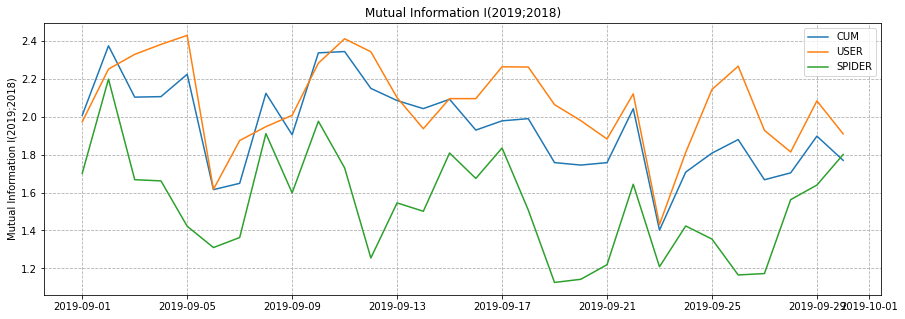

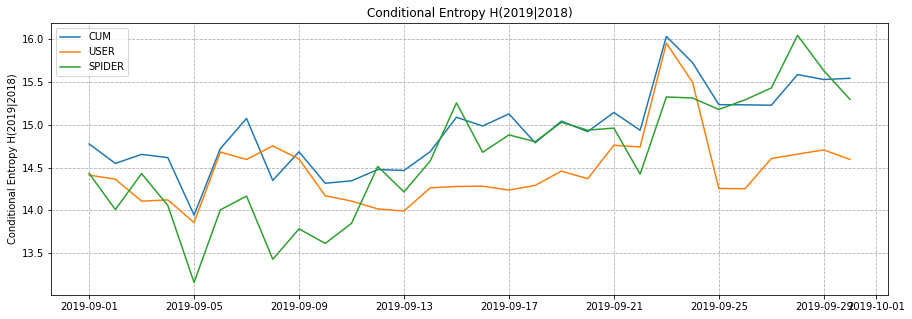

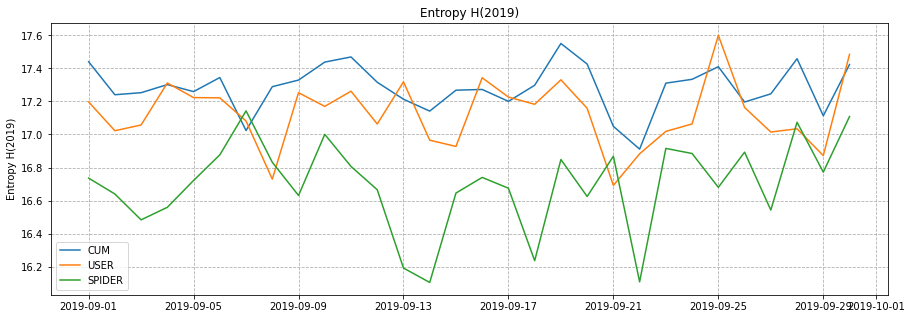

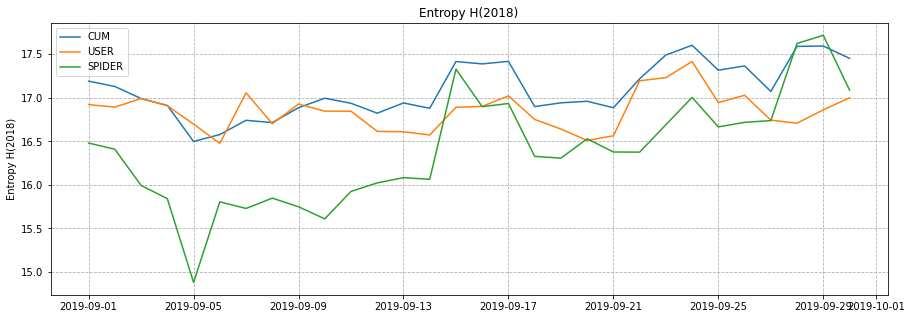

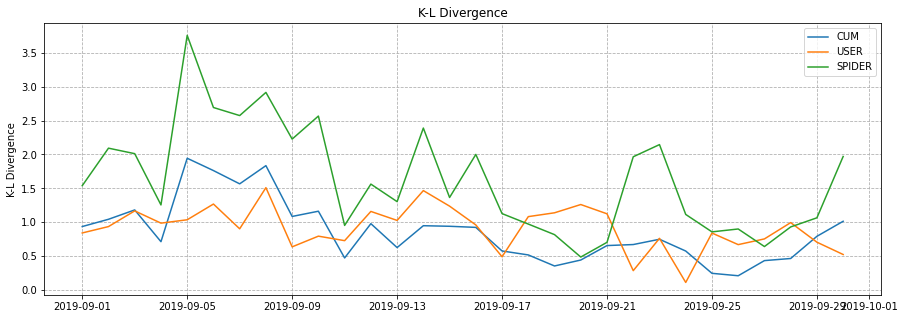

In [68]:
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Mutual Information I(2019;2018)")
plt.ylabel("Mutual Information I(2019;2018)")
plt.legend()
plt.show()
    
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Conditional Entropy H(2019|2018)")
plt.ylabel("Conditional Entropy H(2019|2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[1,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2019)")
plt.ylabel("Entropy H(2019)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[0,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2018)")
plt.ylabel("Entropy H(2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("K-L Divergence")
plt.ylabel("K-L Divergence")
plt.legend()
plt.show()

# Including more top domains


In [97]:
df1 = df.copy()

top_domains = extract_top_domain(df1, 5)

df1["frequency"] = 1/df1["sumCount"]
df1 = df1.sort_values(by=["year", "month", "day", "hour", "trafficType", "domain"], ascending=True)
df1 = df1[df1["domain"].isin(top_domains)]
print(df1[df1["year"]==2019].shape)
print(df1[df1["year"]==2018].shape)
assert(df1[df1["year"]==2019].shape==df1[df1["year"]==2018].shape)

(8640, 9)
(8640, 9)


In [98]:
days = np.array(df1["day"].unique())
years = np.array([2018,2019])

KLV_ARRAY_CUM = np.zeros((len(days)))
MI_ARRAY_CUM = np.zeros((len(days)))
CENTROPY_ARRAY_CUM = np.zeros((len(days)))
ENTROPY_CUM = np.zeros((len(years),len(days)))


for i, day in enumerate(days):
    clear_output(wait=True)
    print("DAY: ", day)

    x = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[1])].to_numpy()
    y = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[0])].to_numpy()
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    ENTROPY_CUM[0, i]     = entropy(x, k=2)
    ENTROPY_CUM[1, i]     = entropy(y, k=2)
    MI_ARRAY_CUM[i]       = mi(x,y, k=2)
    KLV_ARRAY_CUM[i]      = kldiv(x,y, k=2)
    CENTROPY_ARRAY_CUM[i] = centropy(x,y, k=2)


traffic = np.array(["user", "spider"])

KLV_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
MI_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
CENTROPY_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
ENTROPY_CUM_TRAF = np.zeros((len(years),len(days), len(traffic)))



for i, day in enumerate(days):
    for j, traf in enumerate(traffic):
        clear_output(wait=True)
        print("DAY: ", day)

        x = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[1]) & (df1["trafficType"]==traf)].to_numpy()
        y = df1.sumCount[(df1["day"]==day) & (df1["year"]==years[0]) & (df1["trafficType"]==traf)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        ENTROPY_CUM_TRAF[0, i, j]     = entropy(x, k=2)
        ENTROPY_CUM_TRAF[1, i, j]     = entropy(y, k=2)
        MI_ARRAY_CUM_TRAF[i, j]       = mi(x,y, k=2)
        KLV_ARRAY_CUM_TRAF[i, j]      = kldiv(x,y, k=2)
        CENTROPY_ARRAY_CUM_TRAF[i, j] = centropy(x,y, k=2)



DAY:  30


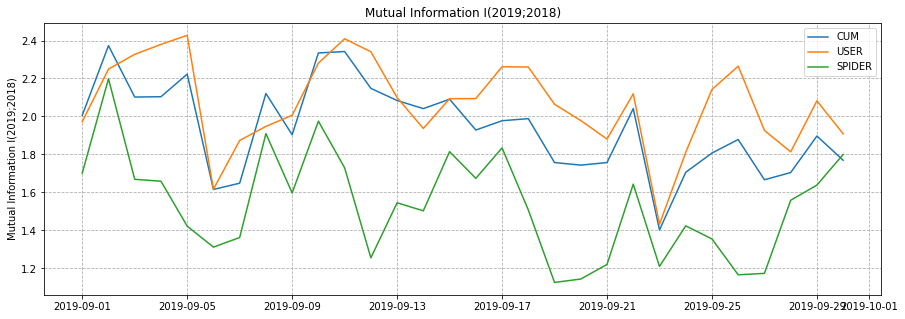

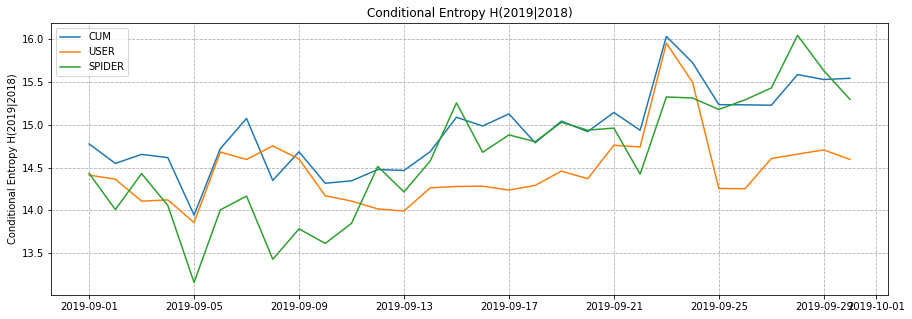

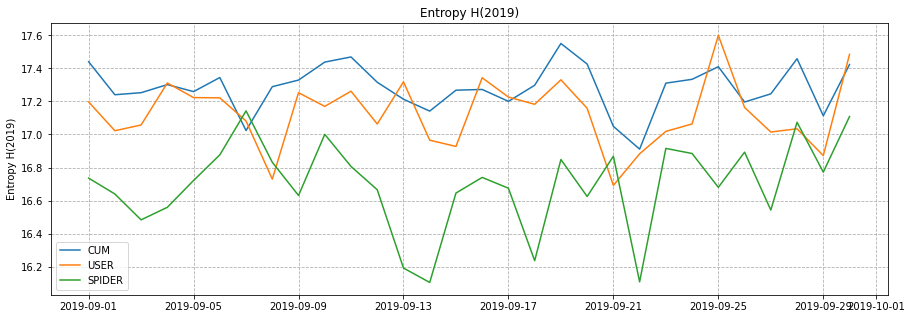

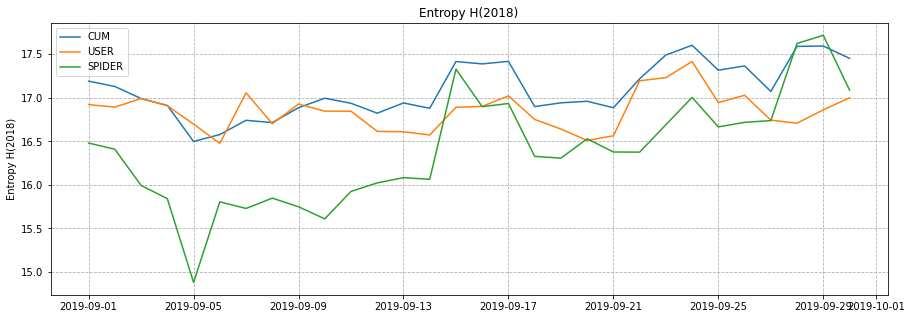

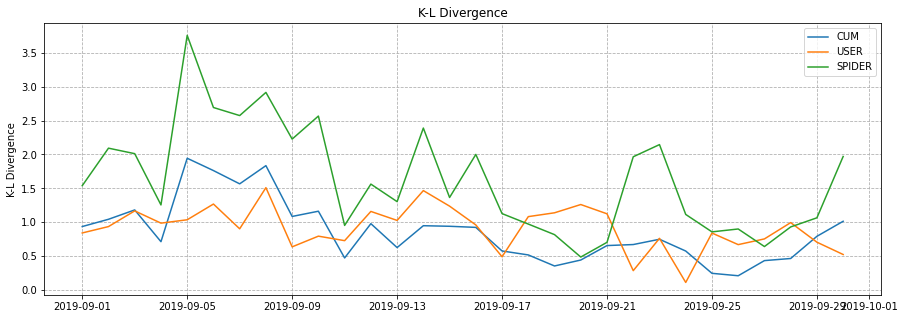

In [99]:
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Mutual Information I(2019;2018)")
plt.ylabel("Mutual Information I(2019;2018)")
plt.legend()
plt.show()
    
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Conditional Entropy H(2019|2018)")
plt.ylabel("Conditional Entropy H(2019|2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[1,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2019)")
plt.ylabel("Entropy H(2019)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[0,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2018)")
plt.ylabel("Entropy H(2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("K-L Divergence")
plt.ylabel("K-L Divergence")
plt.legend()
plt.show()

In [100]:
days = np.array(df1["day"].unique())
years = np.array([2018,2019])

KLV_ARRAY_CUM = np.zeros((len(days)))
MI_ARRAY_CUM = np.zeros((len(days)))
CENTROPY_ARRAY_CUM = np.zeros((len(days)))
ENTROPY_CUM = np.zeros((len(years),len(days)))


for i, day in enumerate(days):
    clear_output(wait=True)
    print("DAY: ", day)

    x = df1.frequency[(df1["day"]==day) & (df1["year"]==years[1])].to_numpy()
    y = df1.frequency[(df1["day"]==day) & (df1["year"]==years[0])].to_numpy()
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    ENTROPY_CUM[0, i]     = entropy(x, k=2)
    ENTROPY_CUM[1, i]     = entropy(y, k=2)
    MI_ARRAY_CUM[i]       = mi(x,y, k=2)
    KLV_ARRAY_CUM[i]      = kldiv(x,y, k=2)
    CENTROPY_ARRAY_CUM[i] = centropy(x,y, k=2)


traffic = np.array(["user", "spider"])

KLV_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
MI_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
CENTROPY_ARRAY_CUM_TRAF = np.zeros((len(days), len(traffic)))
ENTROPY_CUM_TRAF = np.zeros((len(years),len(days), len(traffic)))



for i, day in enumerate(days):
    for j, traf in enumerate(traffic):
        clear_output(wait=True)
        print("DAY: ", day)

        x = df1.frequency[(df1["day"]==day) & (df1["year"]==years[1]) & (df1["trafficType"]==traf)].to_numpy()
        y = df1.frequency[(df1["day"]==day) & (df1["year"]==years[0]) & (df1["trafficType"]==traf)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        ENTROPY_CUM_TRAF[0, i, j]     = entropy(x, k=2)
        ENTROPY_CUM_TRAF[1, i, j]     = entropy(y, k=2)
        MI_ARRAY_CUM_TRAF[i, j]       = mi(x,y, k=2)
        KLV_ARRAY_CUM_TRAF[i, j]      = kldiv(x,y, k=2)
        CENTROPY_ARRAY_CUM_TRAF[i, j] = centropy(x,y, k=2)



DAY:  30


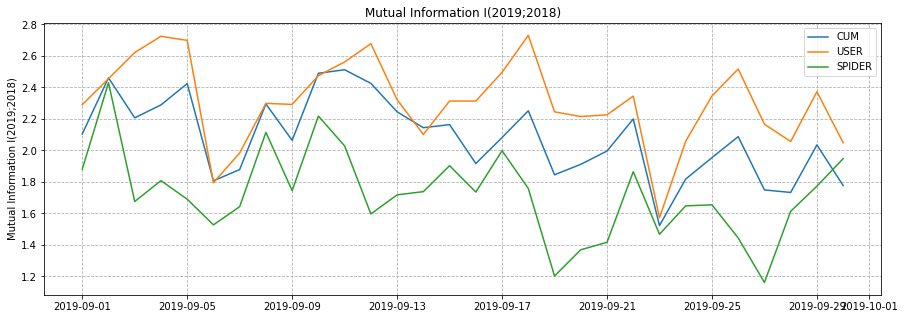

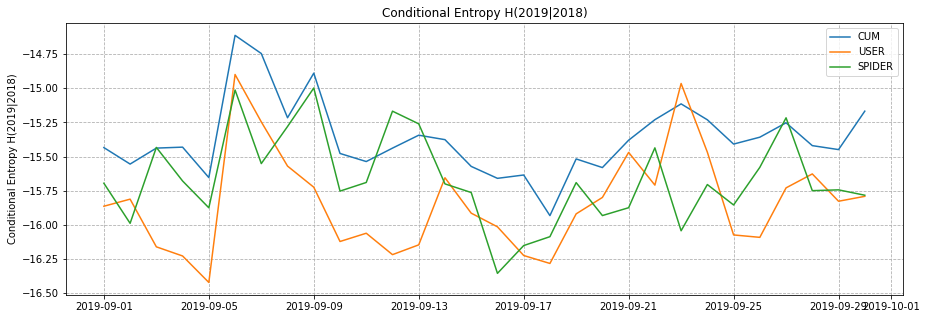

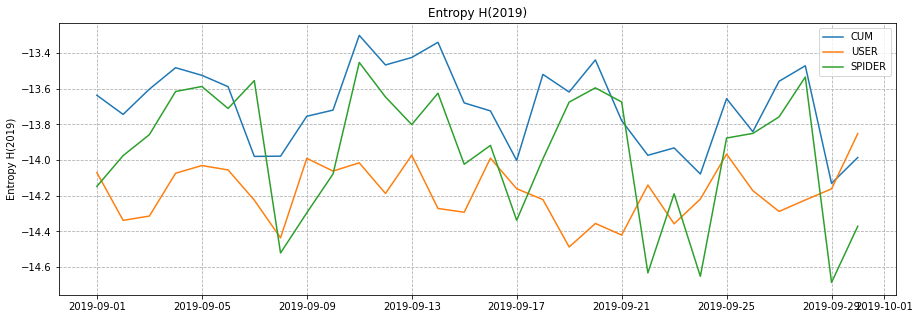

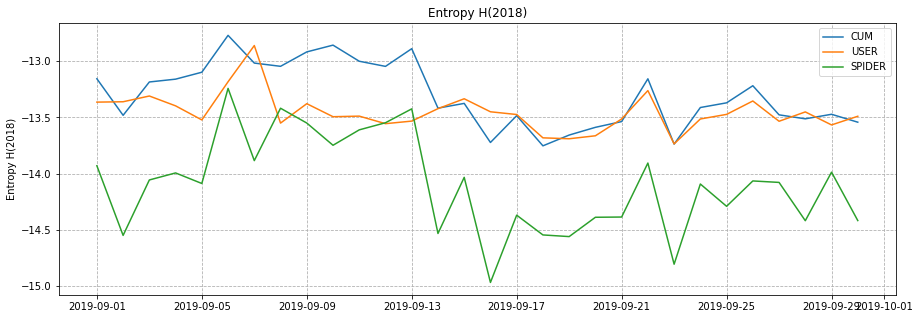

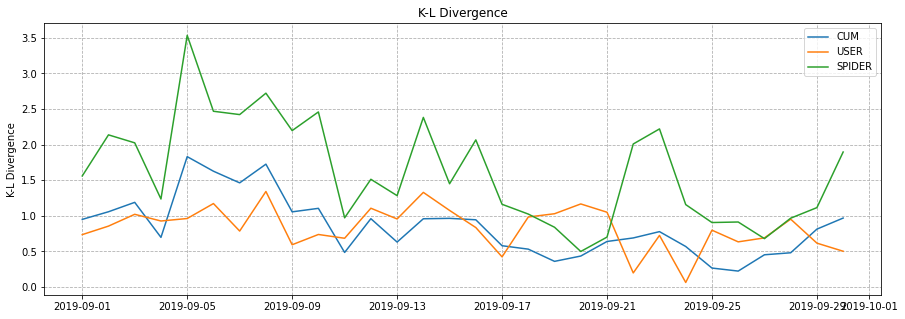

In [101]:
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), MI_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Mutual Information I(2019;2018)")
plt.ylabel("Mutual Information I(2019;2018)")
plt.legend()
plt.show()
    
plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), CENTROPY_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Conditional Entropy H(2019|2018)")
plt.ylabel("Conditional Entropy H(2019|2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[1,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[1, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2019)")
plt.ylabel("Entropy H(2019)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM[0,::], label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0,::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), ENTROPY_CUM_TRAF[0, ::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("Entropy H(2018)")
plt.ylabel("Entropy H(2018)")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM, label="CUM")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,0], label = "USER")
plt.plot(df1.date[(df1["year"]==2019) & (df1["hour"]==0)].unique(), KLV_ARRAY_CUM_TRAF[::,1], label = "SPIDER")
plt.grid(linestyle="--")
plt.title("K-L Divergence")
plt.ylabel("K-L Divergence")
plt.legend()
plt.show()